In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from tqdm import tqdm
import segmentation_models_pytorch as smp
import os
import glob
import nibabel as nib
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

## Load Segmentation Model

In [33]:
root_dir = os.path.join(os.getcwd(), 'data', "ICH_dataset")

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,  # binary segmentation
    activation='sigmoid',  # Use sigmoid activation for binary segmentation
).to(device)

In [43]:
pretrained = r"./output/best_metric_model_095.pth"
state_dict = torch.load(pretrained)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [44]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [59]:
def load_data2D(images, labels, target_size=(128, 128), slice_axis=2):
    """
    Load and resize 2D slices from 3D images and masks from directory using OpenCV.
    """
    data_dicts = []

    for image_name, label_name in zip(images, labels):
        image_data = nib.load(image_name).get_fdata()
        label_data = nib.load(label_name).get_fdata()

        # Extract and resize 2D slices along the specified axis
        for i in range(image_data.shape[slice_axis]):
            image_slice_raw = cv2.resize(image_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            label_slice = cv2.resize(label_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_NEAREST)
            
            # Duplicate the single channel to create a 3-channel image
            image_slice = cv2.merge([image_slice_raw, image_slice_raw, image_slice_raw])

            # Add channel dimension as the first dimension
            image_slice = np.moveaxis(image_slice, -1, 0)
            label_slice = np.expand_dims(label_slice, axis=0)

            # Create a dictionary for each pair of resized 2D image and label slices
            data_dicts.append({"image": image_slice, "label": label_slice})

    return data_dicts


def window_transform(data_dicts, window_centers, window_widths):
    """
    Apply different window transformation to create 3 channel images
    Convert label to binary 0 or 1.
    """
    for data_dict in data_dicts:
        image, label = data_dict["image"], data_dict["label"]
        
        # Apply intensity windowing to each channel separately
        for i in range(image.shape[0]):
            window_center = window_centers[i]
            window_width = window_widths[i]

            # Clip and normalize each channel
            image[i] = np.clip(image[i], window_center - window_width // 2, window_center + window_width // 2)
            image[i] = (image[i] - (window_center - window_width // 2)) / window_width

        # Convert label to binary 0 or 1
        label = np.where(label > 0, 1, 0)
        
        data_dict["image"], data_dict["label"] = image, label
    return data_dicts

In [89]:
images = sorted(glob.glob(os.path.join("./data/ICH_dataset", "ct_scans", "*.nii")))
labels = sorted(glob.glob(os.path.join("./data/ICH_dataset", "masks", "*.nii")))

In [90]:
# images = sorted(glob.glob(os.path.join("data", "Brain Hemorrhage Segmentation Dataset", "images", "*.nii*")))
# labels = sorted(glob.glob(os.path.join("data", "Brain Hemorrhage Segmentation Dataset", "ground truths", "*.nii*")))
print(len(images), len(labels))   

75 75


In [91]:
# load data 
data_dicts = load_data2D(images, labels)

In [93]:
# check shape 
data_dicts[0]["image"].shape, data_dicts[0]["label"].shape 

((3, 128, 128), (1, 128, 128))

In [94]:
# apply window transform
data = window_transform(data_dicts, [40, 100, 400], [120, 200, 1800])

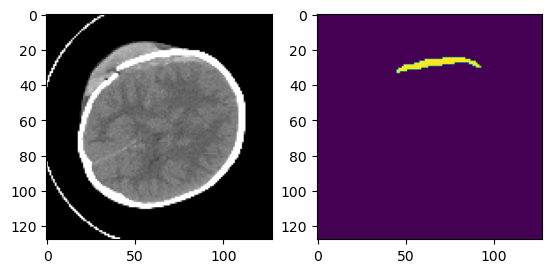

In [95]:
plt.subplot(1, 2, 1)
plt.imshow(data[100]["image"][0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(data[100]["label"][0])
plt.show()

In [96]:
def predict(model, data):
    """
    Make predictions on preprocessed data.
    """
    predictions = []
    model.eval()
    for i in tqdm(range((len(data)))):
        data[i]["image"] = torch.tensor(data[i]["image"], dtype=torch.float32)
        data[i]["label"] = torch.tensor(data[i]["label"], dtype=torch.float32)
        data[i]["image"] = torch.unsqueeze(data[i]["image"], dim=0)
        data[i]["label"] = torch.unsqueeze(data[i]["label"], dim=0)
    with torch.no_grad():
        for i in tqdm(range(len(data))):
            pred = model(data[i]["image"].to(device))
            pred_mask = (pred > 0.5).float().detach().cpu().numpy()
            predictions.append(pred_mask)
    return predictions

In [72]:
# test_ds = CacheDataset(data=, cache_rate=1.0, num_workers=4)
# test_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

In [97]:
predictions = predict(model, data)

100%|██████████| 2814/2814 [00:12<00:00, 216.99it/s]


In [74]:
len(predictions)

2814

In [118]:
def display_pred(predictions, data, start_slice=0, end_slice=10):
    """
    Display prediction and ground truth.
    """
    
    for i in range(start_slice, end_slice):
        plt.figure(figsize=(8,6))
       
        plt.subplot(1, 3, 1) 
        plt.imshow(data[i]["image"][0][0], cmap="gray")
        plt.title(f"Image {i}")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(data[i]["label"][0][0])
        plt.title(f"label {i}")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i][0][0])
        plt.title(f"Prediction {i}")
        plt.axis("off")
        
    plt.show()

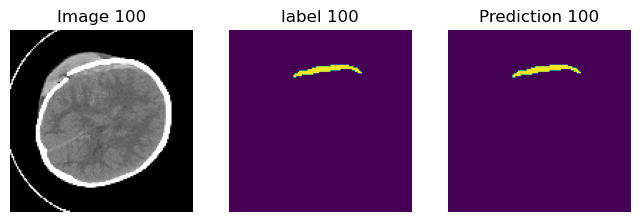

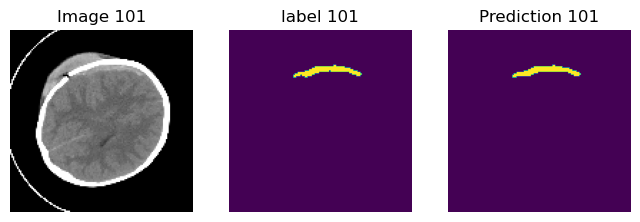

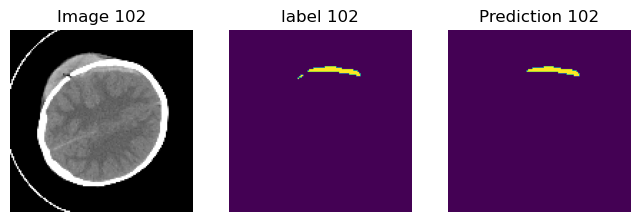

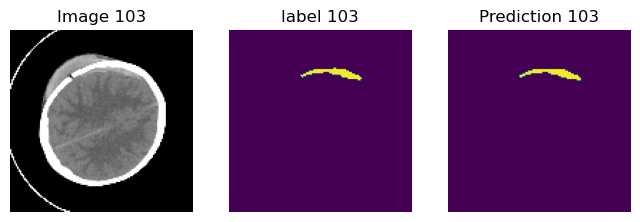

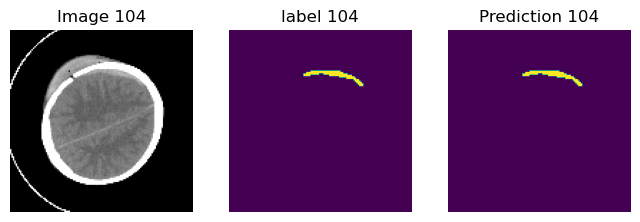

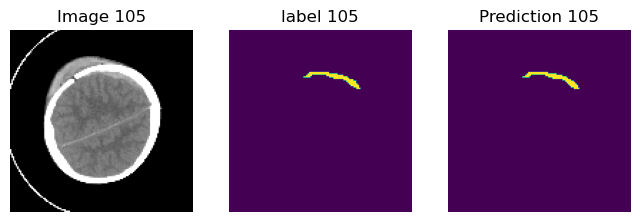

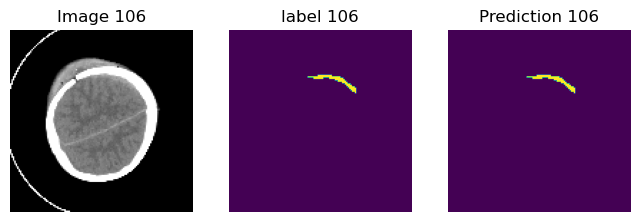

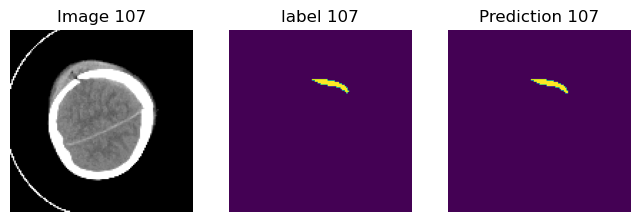

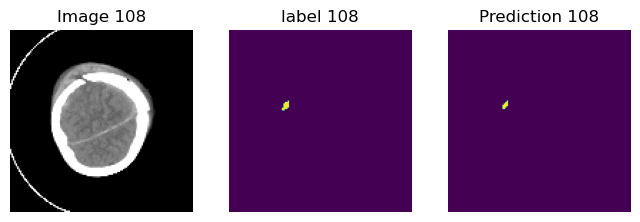

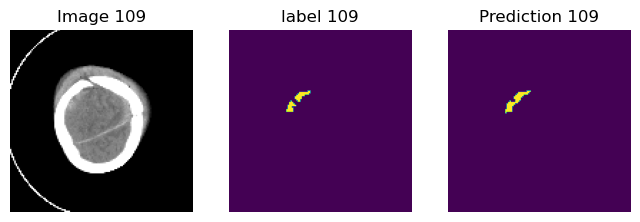

In [119]:
display_pred(predictions, data, start_slice=100, end_slice=110)

In [100]:
model.eval()
val_iou = []
val_sen = []
val_spe = []
val_dice = []
with torch.no_grad():
    for i in range(len(predictions)):
        # calculate dice score between predicted and target masks
        pred = torch.tensor(predictions[i], dtype=torch.float32)
        label = data[i]["label"]
        image = data[i]["image"]
        
        # calculate TP, FP, TN, FN
        # only consider slices with positive pixels
        
        if pred.sum() > 0:
            
            TP = torch.sum(pred * label)
            FP = torch.sum(pred * (1 - label))
            TN = torch.sum((1 - pred) * (1 - label))
            FN = torch.sum((1 - pred) * label)
            
            
            # sensitivity = TP / (TP + FN)
            # specificity = TN / (TN + FP)
            # precision = TP / (TP + FP)
            # accuracy = (TP + TN) / (TP + TN + FP + FN)
            # dice = 2 * TP / (2 * TP + FP + FN)
            # iou = TP / (TP + FP + FN)
            
            sensitivity = (TP + 1e-15) / (TP + FN + 1e-15)
            specificity = (TN + 1e-15) / (TN + FP + 1e-15)
            iou = (TP + 1e-15) / (TP + FP + FN + 1e-15)
            dice = (2 * TP + 1e-15) / (2 * TP + FP + FN + 1e-15)
            
            val_iou.append(iou.item())
            val_sen.append(sensitivity.item())
            val_spe.append(specificity.item())
            val_dice.append(dice.item())

In [101]:
print("mean IoU:", np.mean(val_iou))
print("mean sensitivity:", np.mean(val_sen))
print("mean specificity:", np.mean(val_spe))
print("mean dice:", np.mean(val_dice))

mean IoU: 0.9331106374534174
mean sensitivity: 0.9586762364584798
mean specificity: 0.9998544052766916
mean dice: 0.9625037709554545


In [102]:
def extract_pos_slice(data_dicts):
    """
    Extract positive slices from data_dicts.
    """
    pos_data_dicts = []
    for data_dict in data_dicts:
        if np.sum(data_dict["label"]) > 0:
            pos_data_dicts.append(data_dict)
    return pos_data_dicts

## Data Preproceessing for Multi-label Classification

In [104]:
path = os.path.join("./data/ICH_dataset", 'hemorrhage_diagnosis_raw_ct.csv')
# os.path.exists(path)

data_raw = pd.read_csv(path)

# remove the fracture column
data_raw = data_raw.drop('Fracture_Yes_No', axis=1)

print(data_raw.shape)

data_raw.head()

(2814, 8)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage
0,49,1,0,0,0,0,0,1
1,49,2,0,0,0,0,0,1
2,49,3,0,0,0,0,0,1
3,49,4,0,0,0,0,0,1
4,49,5,0,0,0,0,0,1


In [107]:
len(predictions)

2814

In [108]:
num_class = len(data_raw.columns[2:])
print(f"number of classes: {num_class}")
for i in range(num_class):
    print(f"number of {data_raw.columns[i+2]} samples: {data_raw[data_raw.columns[i+2]].sum()}")


number of classes: 6
number of Intraventricular samples: 24
number of Intraparenchymal samples: 73
number of Subarachnoid samples: 18
number of Epidural samples: 173
number of Subdural samples: 56
number of No_Hemorrhage samples: 2496


In [109]:
categories = list(data_raw.columns.values[2:])
categories

['Intraventricular',
 'Intraparenchymal',
 'Subarachnoid',
 'Epidural',
 'Subdural',
 'No_Hemorrhage']

In [110]:
data_raw.iloc[:, 2:].sum().values

array([  24,   73,   18,  173,   56, 2496], dtype=int64)

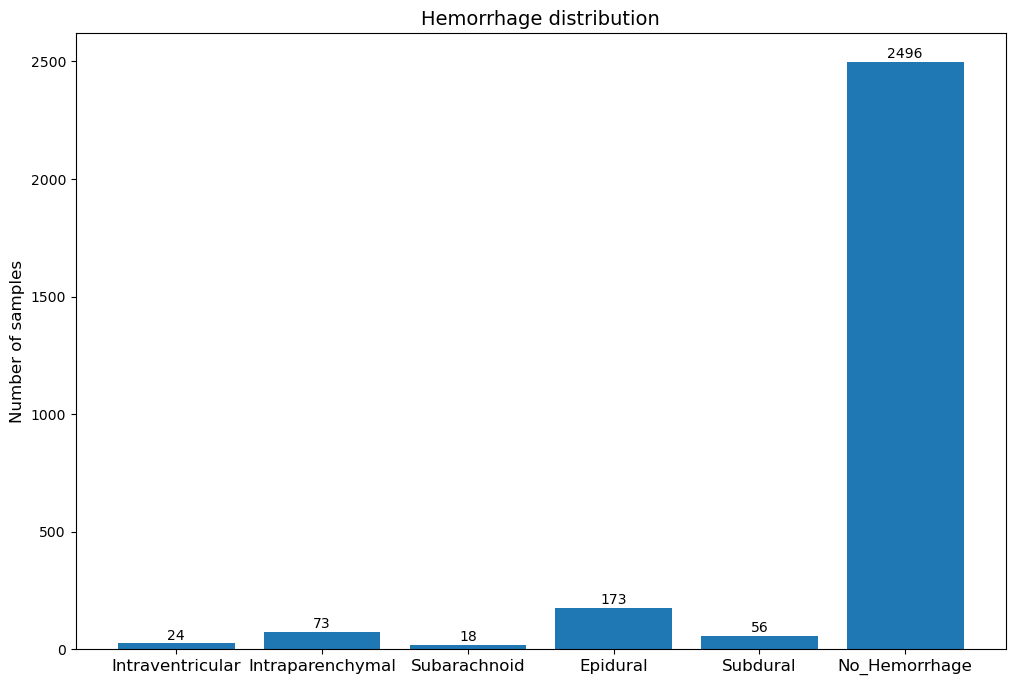

In [112]:
plt.figure(figsize=(12, 8))
plt.bar(categories, data_raw.iloc[:, 2:].sum().values)

plt.title("Hemorrhage distribution", fontsize=14)
plt.ylabel('Number of samples', fontsize=12)

# Adding the text labels
for i, value in enumerate(data_raw.iloc[:, 2:].sum().values):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')
plt.xticks(ha='center', fontsize=12)

plt.show()

In [113]:
# check distribution on number of labels per image
# one image can have multiple labels (multiple hemorrhages)
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts

1    2789
2      24
3       1
dtype: int64

In [354]:
# create ground truth label for each image
ground_truth = data_raw[data_raw.columns[2:]].values
ground_truth[0].shape

(6,)

In [341]:
# create model input 1x128x128
input = []
for p in predictions:
    input.append(p[0])
input = np.array(input)

In [343]:
device

device(type='cuda', index=0)

In [431]:
# shuffle the data and maintain the same order 
random.seed(42)
zipped = list(zip(input, ground_truth, data))
random.shuffle(zipped)
input, ground_truth, data = zip(*zipped)

In [433]:
X_train_tensor = torch.tensor(np.array(input), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(ground_truth), dtype=torch.float32)

# Split the data into training and validation sets
val_percent = 0.2
val_size = int(len(X_train_tensor) * val_percent)
X_val, y_val = X_train_tensor[:val_size], y_train_tensor[:val_size]
X_train, y_train = X_train_tensor[val_size:], y_train_tensor[val_size:]

# Define neural network model for multi-label classification
class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        self.cov1 = nn.Conv2d(1, 16, 5, padding=2)
        self.cov2 = nn.Conv2d(16, 32, 5, padding=2)
        self.cov3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 200) 
        self.fc2 = nn.Linear(200, 84)
        self.fc3 = nn.Linear(84, 6)
    
    def forward(self, x):
        out = self.pool(F.relu(self.cov1(x)))
        out = self.pool(F.relu(self.cov2(out)))
        out = self.pool(F.relu(self.cov3(out)))
        out = out.view(-1, 64 * 16 * 16)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model = MultiLabelCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Add a channel dimension (1 for grayscale)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Print loss each epoch
    print("Epoch {} Loss: {:.4f}".format(epoch + 1, running_loss / len(train_loader)))

Epoch 1 Loss: 0.1524
Epoch 2 Loss: 0.0445
Epoch 3 Loss: 0.0313
Epoch 4 Loss: 0.0250
Epoch 5 Loss: 0.0239
Epoch 6 Loss: 0.0238
Epoch 7 Loss: 0.0211
Epoch 8 Loss: 0.0224
Epoch 9 Loss: 0.0197
Epoch 10 Loss: 0.0142
Epoch 11 Loss: 0.0127
Epoch 12 Loss: 0.0130
Epoch 13 Loss: 0.0124
Epoch 14 Loss: 0.0127
Epoch 15 Loss: 0.0111
Epoch 16 Loss: 0.0099
Epoch 17 Loss: 0.0122
Epoch 18 Loss: 0.0112
Epoch 19 Loss: 0.0111
Epoch 20 Loss: 0.0103
Epoch 21 Loss: 0.0098
Epoch 22 Loss: 0.0085
Epoch 23 Loss: 0.0077
Epoch 24 Loss: 0.0070
Epoch 25 Loss: 0.0070
Epoch 26 Loss: 0.0066
Epoch 27 Loss: 0.0066
Epoch 28 Loss: 0.0069
Epoch 29 Loss: 0.0062
Epoch 30 Loss: 0.0058
Epoch 31 Loss: 0.0068
Epoch 32 Loss: 0.0061
Epoch 33 Loss: 0.0068
Epoch 34 Loss: 0.0059
Epoch 35 Loss: 0.0059
Epoch 36 Loss: 0.0070
Epoch 37 Loss: 0.0060
Epoch 38 Loss: 0.0059
Epoch 39 Loss: 0.0057
Epoch 40 Loss: 0.0057
Epoch 41 Loss: 0.0069
Epoch 42 Loss: 0.0062
Epoch 43 Loss: 0.0059
Epoch 44 Loss: 0.0057
Epoch 45 Loss: 0.0062
Epoch 46 Loss: 0.00

In [449]:
# save the model
torch.save(model.state_dict(), './output/multilabel_class_12_29.pth')

## Evaluation

In [ ]:
with torch.no_grad():
    model.eval()
    val_outputs = model(X_val.to(device))
    val_loss = criterion(val_outputs, y_val.to(device))

    threshold = 0.5
    val_predictions = (torch.sigmoid(val_outputs) > threshold).float()
    
    y_val_np = y_val.cpu().numpy()
    val_predictions_np = val_predictions.cpu().numpy()

    # Calculate accuracy for each class
    accuracies_per_class = []
    for i in range(y_val.shape[1]):
        cor = (y_val_np[:, i] == val_predictions_np[:, i]).sum()
        acc = cor / y_val.shape[0]
        accuracies_per_class.append(acc)

In [451]:
for c in categories:
    print(f"{c} Accuracy: {accuracies_per_class[categories.index(c)] * 100:.2f}%")

Intraventricular Accuracy: 99.64%
Intraparenchymal Accuracy: 99.64%
Subarachnoid Accuracy: 99.29%
Epidural Accuracy: 99.11%
Subdural Accuracy: 100.00%
No_Hemorrhage Accuracy: 100.00%


In [434]:
# find labels with multiple hemorrhages
for i in range(len(y_val)):
    if y_val[i].sum() > 1:
        print(i)

53
344
470


In [454]:
print(y_val[470])
print(torch.sigmoid(val_outputs[470]) > threshold)

tensor([1., 1., 1., 0., 0., 0.])
tensor([False,  True,  True, False, False, False], device='cuda:0')


In [455]:
print(y_val[53])
print(torch.sigmoid(val_outputs[53]) > threshold)

tensor([1., 1., 0., 0., 0., 0.])
tensor([ True,  True, False, False, False, False], device='cuda:0')


In [456]:
print(y_val[344])
print(torch.sigmoid(val_outputs[344]) > threshold)

tensor([0., 1., 0., 1., 0., 0.])
tensor([False, False, False,  True, False, False], device='cuda:0')


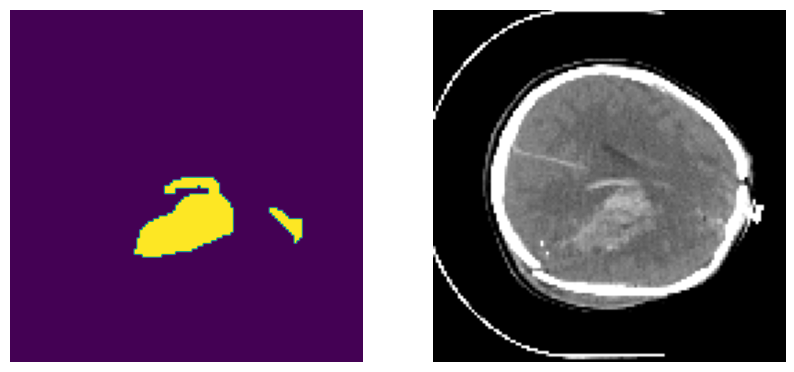

In [447]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(X_val[470].cpu().numpy()[0, :, :], cmap='viridis')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(data[470]["image"][0, 0, :, :], cmap="gray")